# Tutorial: Train and validate models

- 1. Load data and related packages
- 2. Train various models
    - 2.1 Train and tune LightGBM
    - 2.2 Visualize the results
    - 2.3 Save and load your Trainer
    - 2.4 Train other models
- 3. Cross validate models

## 1. Load data and related packages

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

UCI Adult data are going to be used in this tutorial. The data contain both numerical and categorical features, and the target to predict is whether a person makes over 50K a year. It is a very simple binary classification task.

In [2]:
from catboost.datasets import adult
train, test = adult()

In [4]:
target_dict = {
    '<=50K': 0,
    '>50K': 1
}
train['income'] = train['income'].map(target_dict)
test['income'] = test['income'].map(target_dict)

In [5]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,0
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,0
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,0
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,0
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,0


In [6]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32561 non-null  float64
 1   workclass       30725 non-null  object 
 2   fnlwgt          32561 non-null  float64
 3   education       32561 non-null  object 
 4   education-num   32561 non-null  float64
 5   marital-status  32561 non-null  object 
 6   occupation      30718 non-null  object 
 7   relationship    32561 non-null  object 
 8   race            32561 non-null  object 
 9   sex             32561 non-null  object 
 10  capital-gain    32561 non-null  float64
 11  capital-loss    32561 non-null  float64
 12  hours-per-week  32561 non-null  float64
 13  native-country  31978 non-null  object 
 14  income          32561 non-null  int64  
dtypes: float64(6), int64(1), object(8)
memory usage: 3.7+ MB


Let's prepare the data. We need to encode categorical features.

In [8]:
from kuma_utils.preprocessing import (
    PrepPipeline, SelectCategorical, SelectNumerical, DistTransformer, Cast)
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder

In [9]:
num_enc = PrepPipeline([
    SelectNumerical(exclude_cols=['income']),
    DistTransformer('standard'), 
    Cast(float)
])

cat_enc = PrepPipeline([
    SelectCategorical(exclude_cols=['income']),
    OrdinalEncoder(
        encoded_missing_value=np.nan, 
        handle_unknown='use_encoded_value', 
        unknown_value=np.nan),
    Cast(float)
])

In [10]:
train_cat, train_num = cat_enc.fit_transform(train), num_enc.fit_transform(train)
categorical_index = list(range(train_cat.shape[1]))
train_encoded = pd.concat([train_cat, train_num], axis=1) 
train_encoded.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,6.0,9.0,4.0,0.0,1.0,4.0,1.0,38.0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429
1,5.0,9.0,2.0,3.0,0.0,4.0,1.0,38.0,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153
2,3.0,11.0,0.0,5.0,1.0,4.0,1.0,38.0,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429
3,3.0,1.0,2.0,5.0,0.0,2.0,1.0,38.0,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429
4,3.0,9.0,2.0,9.0,5.0,2.0,0.0,4.0,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429


Looks good to me. Let's apply the same transform to test data.

In [11]:
test_encoded = pd.concat([cat_enc.transform(test), num_enc.transform(test)], axis=1)
test_encoded.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,3.0,1.0,4.0,6.0,3.0,2.0,1.0,38.0,-0.995706,0.350774,-1.197459,-0.145920,-0.21666,-0.035429
1,3.0,11.0,2.0,4.0,0.0,4.0,1.0,38.0,-0.042642,-0.947095,-0.420060,-0.145920,-0.21666,0.774468
2,1.0,7.0,2.0,10.0,0.0,4.0,1.0,38.0,-0.775768,1.394362,0.746039,-0.145920,-0.21666,-0.035429
3,3.0,15.0,2.0,6.0,0.0,2.0,1.0,38.0,0.397233,-0.279070,-0.031360,0.895083,-0.21666,-0.035429
4,NaN,15.0,4.0,NaN,3.0,4.0,0.0,38.0,-1.508894,-0.817458,-0.031360,-0.145920,-0.21666,-0.845327


In [12]:
labels, features = train['income'], train_encoded
labels_test, features_test = test['income'], test_encoded

## 2. Train models
Before going to training, let's define our evaluation metric. Since the task is binary classification, I will use ROC-AUC for evaluation.

In [13]:
from sklearn.metrics import roc_auc_score, make_scorer
from kuma_utils.training import Trainer, auc_metric, acc_metric

### 2.1 Use Trainer

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2)

In [15]:
params = {
    'objective': 'binary',
    'metric': 'auc',
}
fit_params = {
    'num_boost_round': 500,
    'callbacks': [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)]
}

trn = Trainer(LGBMClassifier)
trn.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    # logger='path_to_log', 
    params=params, fit_params=fit_params, 
)

Logger created at 24/02/09:06:01:32
[LightGBM] [Info] Number of positive: 6248, number of negative: 19800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239865 -> initscore=-1.153421
[LightGBM] [Info] Start training from score -1.153421
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.921456	valid_1's auc: 0.911351
[20]	training's auc: 0.928525	valid_1's auc: 0.916446
[30]	training's auc: 0.932852	valid_1's auc: 0.920299
[40]	training's auc: 0.936938	valid_1's auc: 0.923435
[50]	training's auc: 0.94008	valid_1's auc: 0.924546
[60]	training's auc: 0.943043	valid_1's auc: 0.925435
[70]	training's auc: 0.9

In [16]:
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 186
best_score: 0.926451535937205

In [17]:
roc_auc_score(labels_test, trn.predict_proba(features_test)[:, 1])

0.9261251382906142

Also, Trainer class has a built-in optuna function. Just set `tune_model=True` and it will search the best hyperparameters. Don't forget to set `n_trials` or `timeout` to prevent endless tuning (For LightGBM models, tuning will be terminated by itself).

**Model tuning for lightgbm is currently work in progress due to breaking changes :(**

In [18]:
# trn = Trainer(LGBMClassifier)
# trn.train(
#     train_data=(x_train, y_train), 
#     valid_data=(x_valid, y_valid),
#     cat_features=categorical_index,
#     params=params, fit_params=fit_params,
#     tune_model=True
# )

In [39]:
# roc_auc_score(labels_test, trn.predict_proba(features_test)[:, 1])

In [38]:
# trn

Custom metrics are available.

In [21]:
from kuma_utils.metrics import SensitivityAtFixedSpecificity

params = {
    'objective': 'binary',
    'metric': 'SensitivityAtFixedSpecificity',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 500,
    'callbacks': [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(25)],
    'feval': SensitivityAtFixedSpecificity(sp=0.9).lgbm
}

trn = Trainer(LGBMClassifier)
trn.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    # logger='path_to_log', 
    params=params, fit_params=fit_params, 
)

specify optimization direction for metric SensitivityAtFixedSpecificity.
Logger created at 24/02/09:06:01:36
Training until validation scores don't improve for 50 rounds


[25]	training's SensitivityAtFixedSpecificity: 0.765845	valid_1's SensitivityAtFixedSpecificity: 0.730069
[50]	training's SensitivityAtFixedSpecificity: 0.790493	valid_1's SensitivityAtFixedSpecificity: 0.749529
[75]	training's SensitivityAtFixedSpecificity: 0.808739	valid_1's SensitivityAtFixedSpecificity: 0.753296
[100]	training's SensitivityAtFixedSpecificity: 0.824264	valid_1's SensitivityAtFixedSpecificity: 0.751412
Early stopping, best iteration is:
[71]	training's SensitivityAtFixedSpecificity: 0.806018	valid_1's SensitivityAtFixedSpecificity: 0.755807


### 2.2 Visualize the results

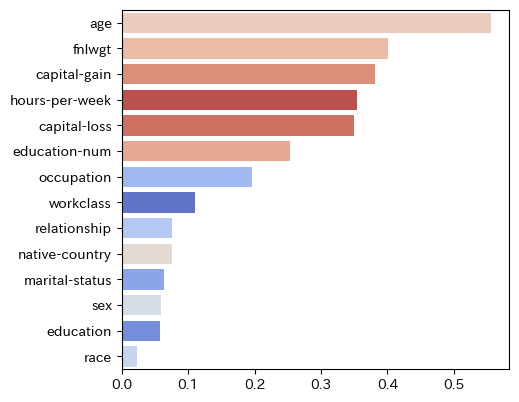

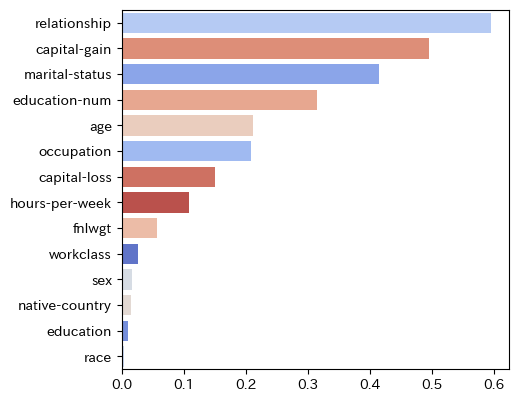

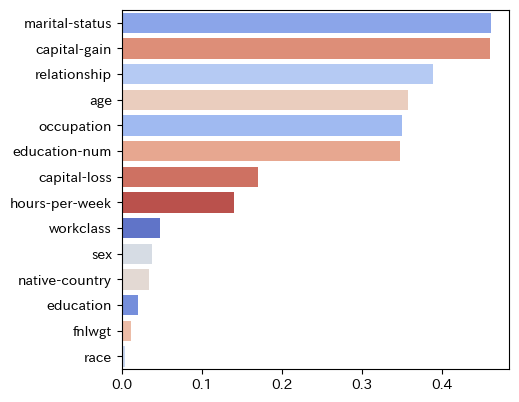

In [22]:
trn.plot_feature_importance()
trn.plot_feature_importance('gain')
trn.plot_feature_importance(
    'permutation', fit_params={
        'X': x_valid, 'y': y_valid, 'scoring': make_scorer(roc_auc_score), 'n_jobs': -1})

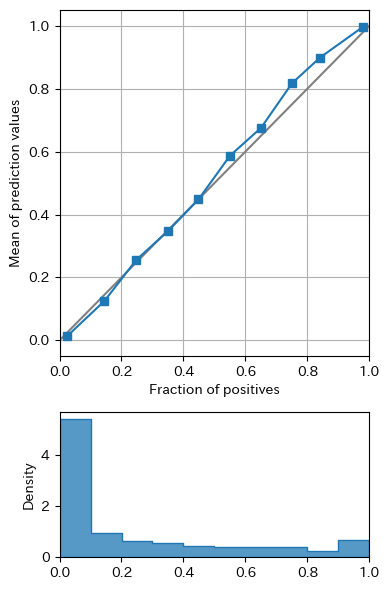

In [23]:
trn.plot_calibration_curve(data=(x_train, y_train))

### 2.3 Save and load Trainer

In [24]:
trn.save('lgbm0.trainer')
trn = Trainer(path='lgbm0.trainer')
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 71
best_score: 0.6610169491525424

### 2.4 Train other models

In [25]:
params = {
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': 100,
    'use_best_model': True,
} 
fit_params = {
    'early_stopping_rounds': 10,
    'verbose_eval': 25
}

# Preprecessing for CatBoost
x_train_cat = x_train.copy()
x_valid_cat = x_valid.copy()
features_test_cat = features_test.copy()
x_train_cat.iloc[:, categorical_index] = x_train_cat.iloc[:, categorical_index].astype('str')
x_valid_cat.iloc[:, categorical_index] = x_valid_cat.iloc[:, categorical_index].astype('str')
features_test_cat.iloc[:, categorical_index] = features_test_cat.iloc[:, categorical_index].astype('str')


trn2 = Trainer(CatBoostClassifier)
trn2.train(
    train_data=(x_train_cat, y_train), 
    valid_data=(x_valid_cat, y_valid),
    cat_features=categorical_index,
    params=params,
    tune_model=True, n_trials=20,
    fit_params=fit_params)

Logger created at 24/02/09:06:01:40
06:01:41 [trial    0] New best: 0.912142 
{ 'boosting_type': 'Plain',
  'bootstrap_type': 'MVS',
  'colsample_bylevel': 0.07660024751466035,
  'depth': 11,
  'objective': 'CrossEntropy'}
06:01:41 [trial    6] New best: 0.913500 
{ 'boosting_type': 'Plain',
  'bootstrap_type': 'MVS',
  'colsample_bylevel': 0.07934288617445939,
  'depth': 7,
  'objective': 'Logloss'}


In [26]:
roc_auc_score(labels_test, trn2.smart_predict(features_test_cat))

0.9153787840295277

In [27]:
params = {
    'booster': 'gbtree', 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'verbosity': 0,
    'num_round': 100,
}
fit_params = {
    'early_stopping_rounds': 10,
    'verbose_eval': False
}

trn3 = Trainer(XGBClassifier)
trn3.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    params=params,
    eval_metric=auc_metric, maximize=True,
    tune_model=True, n_trials=20,
    fit_params=fit_params)

Logger created at 24/02/09:06:01:44


06:01:44 [trial    0] New best: 0.888648 
{ 'alpha': 1.2112310951380829e-06,
  'booster': 'dart',
  'eta': 1.4119814856783533e-05,
  'gamma': 5.989215693368543e-05,
  'grow_policy': 'lossguide',
  'lambda': 3.1238995152023354e-07,
  'max_depth': 6,
  'normalize_type': 'tree',
  'rate_drop': 1.28681485646666e-05,
  'sample_type': 'uniform',
  'skip_drop': 0.00044602025227887627}
06:01:44 [trial    3] New best: 0.898701 
{ 'alpha': 0.008429551713696228,
  'booster': 'dart',
  'eta': 4.8153809273100205e-06,
  'gamma': 0.023808317576383776,
  'grow_policy': 'lossguide',
  'lambda': 0.00015828582802557124,
  'max_depth': 9,
  'normalize_type': 'tree',
  'rate_drop': 0.0001056877167516137,
  'sample_type': 'uniform',
  'skip_drop': 1.252186924320587e-06}
06:01:44 [trial    6] New best: 0.919587 
{ 'alpha': 1.687976556130021e-06,
  'booster': 'dart',
  'eta': 0.517247579920847,
  'gamma': 8.850765671840624e-05,
  'grow_policy': 'lossguide',
  'lambda': 4.013777734433029e-08,
  'max_depth': 8,

In [28]:
roc_auc_score(labels_test, trn3.predict_proba(features_test)[:, 1])

0.9207791174533995

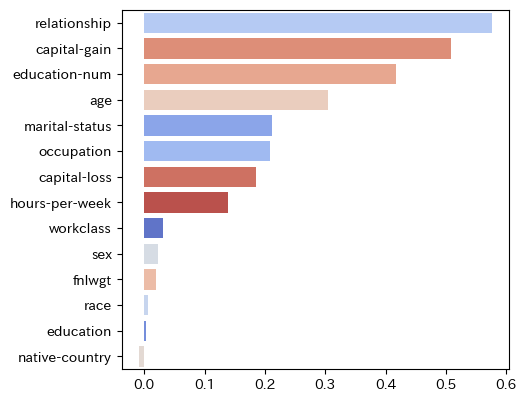

In [29]:
trn3.plot_feature_importance(
    'permutation', fit_params={
        'X': x_valid, 'y': y_valid, 'scoring': make_scorer(roc_auc_score), 'n_jobs': -1})

## 3. Cross validate models

In [30]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 100,
    'callbacks': [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(25)]
}

trn = Trainer(LGBMClassifier)
trn.cv(
    data=(features, labels), 
    cat_features=categorical_index,
    folds=StratifiedKFold(n_splits=5), 
    params=params, fit_params=fit_params, 
)

Logger created at 24/02/09:06:01:47
Training until validation scores don't improve for 50 rounds
[25]	cv_agg's valid auc: 0.922025 + 0.00264879
[50]	cv_agg's valid auc: 0.927481 + 0.00227593
[75]	cv_agg's valid auc: 0.928261 + 0.00211113
[100]	cv_agg's valid auc: 0.928544 + 0.00212961
Did not meet early stopping. Best iteration is:
[96]	cv_agg's valid auc: 0.928548 + 0.00216293
06:01:53 [96]	best score is 0.928548


In [31]:
trn

Trainer: trainer0
model: [LGBMClassifier(), LGBMClassifier(), LGBMClassifier(), LGBMClassifier(), LGBMClassifier()]
is_trained: True
best_iteration: 96
best_score: 0.9285480621915914

In [32]:
roc_auc_score(labels_test, np.stack(trn.smart_predict(features_test)).mean(0))

0.9281075947501107

Note that `Trainer.cv()` is equivalent to `lightgbm.cv()` or `xgboost.cv()`. 

Otherwise, there is a `CrossValidator` class in which you can control details of cross validation operation.

In [33]:
from kuma_utils.training import CrossValidator

In [34]:
validator = CrossValidator(LGBMClassifier)
validator.train(
    data=(features, labels), params=params, fit_params=fit_params,
    folds=StratifiedKFold(n_splits=5)
)

Logger created at 24/02/09:06:01:53
06:01:53 [cv0] Starting fold 0


06:01:55 [cv0] Fold 0: eval=0.925781 (iter=0)
06:01:55 [cv0] Starting fold 1
06:01:57 [cv0] Fold 1: eval=0.923952 (iter=0)
06:01:57 [cv0] Starting fold 2
06:01:59 [cv0] Fold 2: eval=0.929432 (iter=0)
06:01:59 [cv0] Starting fold 3
06:02:00 [cv0] Fold 3: eval=0.928901 (iter=0)
06:02:00 [cv0] Starting fold 4
06:02:02 [cv0] Fold 4: eval=0.929409 (iter=0)
06:02:02 [cv0] Overall metric: 0.927495 + 0.002231


In [35]:
validator

CrossValidator: cv0
models: [Trainer: cv0_fold0
model: LGBMClassifier()
is_trained: True
best_iteration: 0
best_score: 0.9257809196590082
, Trainer: cv0_fold1
model: LGBMClassifier()
is_trained: True
best_iteration: 0
best_score: 0.9239520899379169
, Trainer: cv0_fold2
model: LGBMClassifier()
is_trained: True
best_iteration: 0
best_score: 0.9294320883693283
, Trainer: cv0_fold3
model: LGBMClassifier()
is_trained: True
best_iteration: 0
best_score: 0.9289010772695
, Trainer: cv0_fold4
model: LGBMClassifier()
is_trained: True
best_iteration: 0
best_score: 0.9294094496111551
]
is_trained: True
best_score: [0.9274951249693817, 0.0022309085591902342]

In [36]:
roc_auc_score(labels_test, np.stack(validator.smart_predict(features_test)).mean(0))

0.9275528536219858

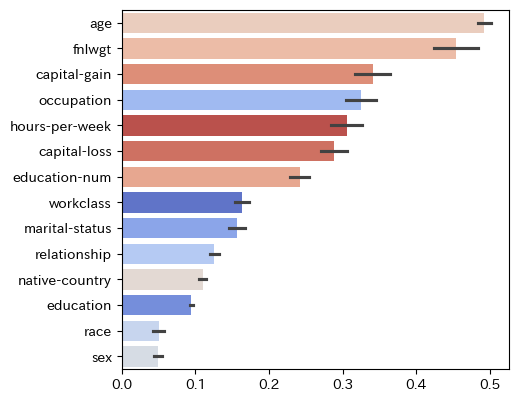

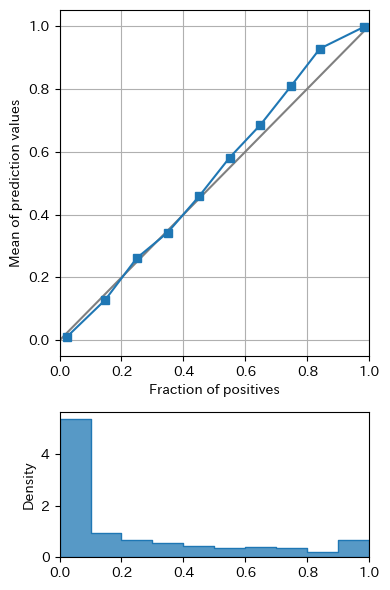

In [37]:
validator.plot_feature_importance(),
validator.plot_calibration_curve(data=(features, labels))